# Model HMXBs using an MCMC algorithm, using available constraints

## Jeff J. Andrews, Andreas Zezas, Tassos Fragkos

Our first goal is to model a HMXB such as PSR J0045-7319 in the SMC:

$$\alpha = 00:45:35.26$$
$$\delta = -73:19:03.32$$
$$P_{\rm orb} = 51.169\ {\rm days} $$
$$e = 0.808$$
$$M_2 \approx 11\ M_{\odot}\ {\rm (B1\ V\ star)}$$ 

In [1]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import interp1d, interp2d
from scipy.stats import maxwell, norm, uniform, powerlaw, truncnorm
from scipy import optimize
import emcee
import corner
from astropy.coordinates import SkyCoord
from astropy import units as u
sys.path.append('../SF_history')
import sf_history


%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


### Constants

In [21]:
G = 6.674e-8 # Gravitational constant in cgs
GGG = 1.909e5 # Gravitational constant in Rsun * (km/s)^2 / Msun
km_to_cm = 1.0e5 # km to cm
Msun_to_g = 1.989e33 # Msun to g
Rsun_to_cm = 6.995e10 # Rsun to cm
AU_to_cm = 1.496e13 # AU to cm
pc_to_cm = 3.086e18 # parsec to cm
pc_to_km = 3.086e13 # parsec to km
yr_to_sec = 31557600.0 # Sec in yr
day_to_sec = 3600.0*24.0 # Sec in day
asec_to_rad = 4.84814e-6 # Arcsec to radians

M_0 = 0.073 # in Msun
xi = 0.704
M_NS = 1.35
#v_wind = 1000.0 # companion velocity in km/s
R_NS = 12.0  # NS radius in km

### Load SSE data

In [3]:
names = ["time","type","mass","mdot","radius"]

f_list = glob.glob("../data/sse_data/mdot_*.dat")

f_list = np.sort(f_list)

# Create empty data storage structure
sse_data = np.recarray(0, names=names, formats=['f8,float64,float64'])

func_sse_mdot = np.array([])
func_sse_mass = np.array([])
func_sse_radius = np.array([])
sse_tmp_mass = np.array([])
sse_tmp_time = np.array([])
sse_tmp_radius = np.array([])
sse_tmp_MS_radius = np.array([])
sse_tmp_ZAMS_radius = np.array([])

for f in f_list:
    datafile = os.path.abspath(f)
#    sse_tmp_data = np.genfromtxt(datafile, usecols=(0,2,3,4), dtype="f8,float64,float64,float64", skip_header=1, names=names)
    sse_tmp_data = np.genfromtxt(datafile, dtype="f8,int,float64,float64,float64", skip_header=1, names=names)
    
#    func_sse_mass = np.append(func_sse_mass, interp1d(sse_tmp_data["time"], sse_tmp_data["mass"], bounds_error=False, fill_value=0.0))    
#    func_sse_mdot = np.append(func_sse_mdot, interp1d(sse_tmp_data["time"], sse_tmp_data["mdot"], bounds_error=False, fill_value=0.0))
    func_sse_mass = np.append(func_sse_mass, interp1d(sse_tmp_data["time"], sse_tmp_data["mass"], bounds_error=False, fill_value=sse_tmp_data["mass"][-1]))    
    func_sse_mdot = np.append(func_sse_mdot, interp1d(sse_tmp_data["time"], sse_tmp_data["mdot"], bounds_error=False, fill_value=0.0))
    func_sse_radius = np.append(func_sse_radius, interp1d(sse_tmp_data["time"], sse_tmp_data["radius"], bounds_error=False, fill_value=0.0))
    
    sse_tmp_time = np.append(sse_tmp_time, max(sse_tmp_data["time"])-1.0)
    sse_tmp_mass = np.append(sse_tmp_mass, sse_tmp_data["mass"][0])
    sse_tmp_ZAMS_radius = np.append(sse_tmp_ZAMS_radius, sse_tmp_data["radius"][0])
    sse_tmp_radius = np.append(sse_tmp_radius, max(sse_tmp_data["radius"]))
    sse_tmp_MS_radius = np.append(sse_tmp_MS_radius, max(sse_tmp_data["radius"][np.where(sse_tmp_data["type"]==1)]))

# Lifetime function
func_sse_tmax = interp1d(sse_tmp_mass, sse_tmp_time, bounds_error=False, fill_value=0.0)
func_sse_min_mass = interp1d(sse_tmp_time, sse_tmp_mass, bounds_error=False, fill_value=1.0)
func_sse_r_ZAMS = interp1d(sse_tmp_mass, sse_tmp_ZAMS_radius, bounds_error=False, fill_value=0.0)
func_sse_rmax = interp1d(sse_tmp_mass, sse_tmp_radius, bounds_error=False, fill_value=0.0)
func_sse_r_MS_max = interp1d(sse_tmp_mass, sse_tmp_MS_radius, bounds_error=False, fill_value=0.0)

In [4]:
def func_get_sse_star(mass, time):

    mass_out = np.array([])
    mdot_out = np.array([])
    radius_out = np.array([])

    if isinstance(mass, np.ndarray):
        
        if len(mass) == 1:
            mass_out = np.append(mass_out, func_sse_mass[int(mass*100.0)-100](time))
            mdot_out = np.append(mdot_out, func_sse_mdot[int(mass*100.0)-100](time))        
            radius_out = np.append(radius_out, func_sse_radius[int(mass*100.0)-100](time))
        else:
            for i in np.arange(len(mass)):
                if (int(mass[i]*100.0)-100<0 or int(mass[i]*100.0)-100>len(func_sse_mass)): continue
                mass_out = np.append(mass_out, func_sse_mass[int(mass[i]*100.0)-100](time[i]))
                mdot_out = np.append(mdot_out, func_sse_mdot[int(mass[i]*100.0)-100](time[i]))
                radius_out = np.append(radius_out, func_sse_radius[int(mass[i]*100.0)-100](time[i]))
    else:
        mass_out = np.append(mass_out, func_sse_mass[int(mass*100.0)-100](time))
        mdot_out = np.append(mdot_out, func_sse_mdot[int(mass*100.0)-100](time))
        radius_out = np.append(radius_out, func_sse_radius[int(mass*100.0)-100](time))
            
    return mass_out, mdot_out, radius_out
    

In [5]:
names = ["mass","he_mass","t_ms"]
f = "../data/sse_data/He_star.dat"

sse_he_star = np.genfromtxt(os.path.abspath(f), usecols=(0,1,2), names=names)

func_sse_he_mass = interp1d(sse_he_star["mass"], sse_he_star["he_mass"], bounds_error=False, fill_value=0.001)
func_sse_ms_time = interp1d(sse_he_star["mass"], sse_he_star["t_ms"], bounds_error=False, fill_value=-1.0e10)

### Binary evolution

In [22]:
# To Do: Check for thermal timescale MT criterion

def func_MT_forward(M_1_in, M_2_in, A_in, ecc_in):

    M_1_out = func_sse_he_mass(M_1_in)
#    M_1_out = M_0 * M_1_in**(1./xi)
    M_2_out = M_1_in + M_2_in - M_1_out
    A_out = A_in * (1.0-ecc_in) * (M_1_in*M_2_in/M_1_out/M_2_out)**2
    
    # Make sure systems don't overfill their Roche lobes
    r_1_max = func_sse_r_MS_max(M_1_out)
    r_1_roche = func_Roche_radius(M_1_in, M_2_in, A_in)
    r_2_max = func_sse_r_MS_max(M_2_out)
    r_2_roche = func_Roche_radius(M_2_in, M_1_in, A_in)
    
    if isinstance(A_out, np.ndarray):
        A_out[np.where(r_1_max > r_1_roche)] = -1.0
        A_out[np.where(r_2_max > r_2_roche)] = -1.0
    else:
        if r_1_max > r_1_roche or r_2_max > r_2_roche: A_out = -1.0
    
    return M_1_out, M_2_out, A_out


def func_Roche_radius(M1, M2, A):
    """ Get Roche lobe radius (Eggleton 1983) """
    q = M1 / M2
    return A * 0.49*q**(2.0/3.0) / (0.6*q**(2.0/3.0) + np.log(1.0 + q**(1.0/3.0)))


def P_to_A(M1, M2, P):
    """ Orbital period (days) to separation (Rsun) """
    mu = G * (M1 + M2) * Msun_to_g
    n = 2.0*np.pi / P / day_to_sec
    A = np.power(mu/(n*n), 1.0/3.0) / Rsun_to_cm
    return A
    
def A_to_P(M1, M2, A):
    """ Orbital separation (Rsun) to period (days) """
    mu = G * (M1 + M2) * Msun_to_g
    n = np.sqrt(mu/(A**3 * Rsun_to_cm**3))
    P = 2.0*np.pi / n
    return P / day_to_sec


In [8]:
def func_SN_forward(M_1_in, M_2, A_in, v_k, theta, phi):
    if isinstance(A_in, np.ndarray):
        A_in[np.where(A_in<=0.0)] = 1.0e-50
    else:
        if A_in<=0.0: A_in = 1.0e-50

    v_r = np.sqrt(GGG*(M_1_in + M_2)/A_in)
    v_1 = np.sqrt(2.0*v_k*v_r*np.cos(theta) + v_k*v_k + v_r*v_r)
    
    A_out = 1.0 / (2.0/A_in - v_1*v_1/(GGG*(M_NS+M_2)))
#    v_sys = (M_NS / (M_NS + M_2)) * v_1

    # Systemic velocity    
    alpha = (M_1_in / (M_1_in + M_2))    
    beta = (M_NS / (M_NS + M_2))
    
    v_sys = beta*beta*v_k*v_k
    v_sys = v_sys + v_r*v_r*(beta-alpha)*(beta-alpha)
    v_sys = v_sys + 2.0*beta*v_k*v_r*np.cos(theta)*(beta-alpha)
    v_sys = np.sqrt(v_sys)
    
    # Eccentricity
    e_tmp = v_k*v_k*np.cos(theta)*np.cos(theta) 
    e_tmp = e_tmp + v_k*v_k*np.sin(theta)*np.sin(theta)*np.sin(phi)*np.sin(phi) 
    e_tmp = e_tmp + 2.0*v_k*v_r*np.cos(theta)
    e_tmp = e_tmp + v_r*v_r
    e_tmp = 1.0 - (A_in*A_in)/(A_out*GGG*(M_NS+M_2)) * e_tmp
        
    if isinstance(e_tmp, np.ndarray):
        
        ecc = np.sqrt(e_tmp)
        ecc[np.where(e_tmp < 0.0)] = -1.0
        ecc[np.where(e_tmp > 1.0)] = -1.0
        ecc[np.where(M_2 < min_mass)] = -1.0
        ecc[np.where(A_in < 1.0e-10)] = -1.0
#        ecc = np.array([np.sqrt(x) if x > 0.0 or M_2 > min_mass or A_in>1.0e-10 else -1.0 for x in e_tmp])
    else:
        if e_tmp < 0.0 or M_2 < min_mass or A_in < 1.0e-10: return A_out, v_sys, -1.0
        ecc = np.sqrt(e_tmp)
    
    return A_out, v_sys, ecc



In [9]:
# To Do: What happens when companion's lifetime falls between primary's MS lifetime and stellar lifetime?
# To Do: Remove RLOF systems

def func_get_time(M1, M2, t_obs):

    t_lifetime_1 = func_sse_ms_time(M1)
    he_mass_1 = func_sse_he_mass(M1)
    
    t_lifetime_2 = func_sse_ms_time(M2)
    he_mass_2 = func_sse_he_mass(M2)
    
    # Relative lifetime through star 2 at mass gain
    he_mass = t_lifetime_1/t_lifetime_2 * he_mass_2
    
    # Get new secondary parameters
    mass_new = M2 + M1 - he_mass_1
    t_lifetime_new = func_sse_ms_time(mass_new)
    he_mass_new = func_sse_he_mass(mass_new)

    # New, effective lifetime
    t_eff = he_mass / he_mass_new * t_lifetime_new
    
    # Now, we obtain the "effective observed time"
    return t_eff + t_obs - t_lifetime_1
         
    
    
def get_v_wind(mass, radius):
    
    slope = (7.0 - 0.5) / (120.0 - 1.4)
    intercept = 7.0 - 120.0 * slope
    
    beta = slope * mass + intercept
    
    
    # For systems with radius = 0.0, set wind arbitrarily high
    if isinstance(radius, np.ndarray):
        one_over_radius = 1.0e50 * np.ones(len(radius))
        one_over_radius[np.where(radius>0.0)] = 1.0 / radius[np.where(radius>0.0)]
    else:
        one_over_radius = 1.0e50
        if radius>0.0: one_over_radius = 1.0/radius
    
    return np.sqrt(2.0 * beta * GGG * mass * one_over_radius)
    
    
    
def func_Lx_forward(M_1_a, M_2_a, M_2_in, A_in, ecc_in, t_obs):
    
    t_eff_obs = func_get_time(M_1_a, M_2_a, t_obs)
    
    if isinstance(t_eff_obs, np.ndarray):
        M_2_out = np.array([])
        M_dot_wind = np.array([])
        R_out = np.array([])
        for i in np.arange(len(t_eff_obs)):
            if (t_eff_obs[i] < 0.0 or ecc_in[i] < 0.0 or ecc_in[i] >= 1.0): 
                ecc_in[i] = 0.0
                if isinstance(M_2_in, np.ndarray):
                    M_2_out = np.append(M_2_out, M_2_in[i])
                else:
                    M_2_out = np.append(M_2_out, M_2_in)
                M_dot_wind = np.append(M_dot_wind, 0.0)
                R_out = np.append(R_out, 0.0)
            else:
                if isinstance(M_2_in, np.ndarray):
                    if M_2_in[i] > max_mass: 
                        a, b, c = 0.0, 0.0, 0.0
                    else:
                        a, b, c = func_get_sse_star(M_2_in[i], t_eff_obs[i])
                else:
                    if M_2_in > max_mass: 
                        a, b, c = 0.0, 0.0, 0.0
                    else:
                        a, b, c = func_get_sse_star(M_2_in, t_eff_obs[i])

                M_2_out = np.append(M_2_out, a)
                M_dot_wind = np.append(M_dot_wind, b)    
                R_out = np.append(R_out, c)
    else:
        if (t_eff_obs < 0.0 or M_2_in > max_mass or ecc_in < 0.0 or ecc_in > 1.0): 
            M_2_out = M_2_in
            M_dot_wind = 0.0
            R_out = 0.0
            ecc_in = 0.0
        else:
            M_2_out, M_dot_wind, R_out = func_get_sse_star(M_2_in, t_eff_obs)

    # Get wind velocity
    v_wind = get_v_wind(M_2_out, R_out)
    if isinstance(v_wind, np.ndarray):
        v_wind[np.where(v_wind <= 0.0)] = 1.0e50 # To eliminate "bad" winds
    else:
        if v_wind <= 0.0: v_wind = 1.0e50
    
    # Get final orbital separation
    if isinstance(A_in, np.ndarray):
        A_in[np.where(A_in <= 0.0)] = 1.0e50 # To eliminate "bad" separations
    else:
        if A_in <= 0.0: A_in = 1.0e50
    A_out = (M_NS + M_2_in) / (M_NS + M_2_out) * A_in
    
    # Capture fraction takes into account eccentricity
    f_capture = (GGG*M_NS / (v_wind*v_wind*A_out))**2 / np.sqrt(1.0 - ecc_in**2)
    M_dot_out = f_capture * M_dot_wind
        
    L_bol = GGG * M_NS * M_dot_out / R_NS * km_to_cm * Msun_to_g * Rsun_to_cm / yr_to_sec
    L_x = L_bol
            
    return M_2_out, L_x, M_dot_out, A_out



### MCMC implementation

In [11]:
min_mass = 8.0
max_mass = 39.0
min_A = 1.0e2
max_A = 1.0e4
v_k_sigma = 265.0
alpha = -2.35

dist_LMC = 5.0e4 * pc_to_km # Distance in km

### Load LMC/SMC star formation histories

In [ ]:
lmc_sfh = sf_history.load_lmc_sfh()
lmc_coor = sf_history.load_lmc_coor()
smc_sfh = sf_history.load_smc_sfh()
smc_coor = sf_history.load_smc_coor()

### Priors

In [12]:
def get_stars_formed(ra, dec, t_min, t_max, v_sys, dist_LMC, N_size=512):
    ran_phi = 2.0*np.pi*uniform.rvs(size = N_size)

    c_1 = 3.0 / np.pi / (t_max - t_min)**3 * (dist_LMC / v_sys)**2
    ran_x = uniform.rvs(size = N_size)
    ran_t_b = (3.0 * ran_x / (c_1 * np.pi * (v_sys/dist_LMC)**2))**(1.0/3.0) + t_min
    
#    c_2 = dist_LMC / (np.pi * v_sys * (ran_t_b - t_min))
    theta_c = v_sys / dist_LMC * (ran_t_b - t_min)
    c_2 = 1.0 / (np.pi * theta_c**2)
    ran_y = uniform.rvs(size = N_size)
    ran_theta = np.sqrt(ran_y / (c_2 * np.pi))
    
    ran_ra = rad_to_dec(ran_theta) * np.cos(ran_phi) / np.cos(dec_to_rad(dec)) + ra
    ran_dec = rad_to_dec(ran_theta) * np.sin(ran_phi) + dec
 
    # Specific star formation rate (Msun/Myr/steradian)
    SFR = get_SFH(ran_ra, ran_dec, ran_t_b/(yr_to_sec*1.0e6), smc_coor, smc_sfh)
    
    return np.mean(SFR)
    
    
    
# Priors
def ln_priors(y):
    
#    M1, M2, A, v_k, theta, phi, ra_b, dec_b, t_b = y
    ra, dec, M1, M2, A, ecc, v_k, theta, phi, ra_b, dec_b, t_b = y
    
    lp = 0.0
                
    # P(M1)
    if M1 < min_mass or M1 > max_mass: return -np.inf
    norm_const = (alpha+1.0) / (np.power(max_mass, alpha+1.0) - np.power(min_mass, alpha+1.0))
    lp += np.log( norm_const * np.power(M1, alpha) )
    
    # M1 must be massive enough to evolve off the MS by t_obs
    if func_sse_tmax(M1) > t_b: return -np.inf

    # P(M2)
    q = M2 / M1
    if q < 0.3 or q > 1.0: return -np.inf
    lp += np.log( (1.0 / 0.7) * (1.0 / M1 ) )

    # P(A)
    if A*(1.0-ecc) < min_A or A*(1.0+ecc) > max_A: return -np.inf
    norm_const = np.log(max_A) - np.log(min_A)
    lp += np.log( norm_const / A )

    # P(ecc)
    if ecc < 0.0 or ecc > 1.0: return -np.inf
    lp += np.log(2.0 * ecc)
    
    # P(v_k)
    if v_k < 0.0: return -np.inf
    lp += np.log( maxwell.pdf(v_k, scale=v_k_sigma) )

    # P(theta)
    if theta <= 0.0 or theta >= np.pi: return -np.inf
    lp += np.log(np.sin(theta) / 2.0)

    # P(phi)
    if phi < 0.0 or phi > 2.0*np.pi: return -np.inf
    lp += -np.log( 2.0*np.pi )

    # Get star formation history
    dist_closest, sfh = get_SFH(ra_b, dec_b, t_b, smc_coor, smc_sfh)
    if sfh == 0.0: return -np.inf

    # P(alpha, delta)
    # Closest point must be within survey. We estimate using the
    # field of view of the CCD in the survey: 24' x 24' which is
    # 0.283 degrees from center to corner. We round up to 0.3
    # Area probability depends only on declination
    if dist_closest > 0.3: return -np.inf    
    lp += np.log(np.cos(dec_to_rad(dec_b)) / 2.0)

    ##################################################################
    # We add an additional prior that scales the RA and Dec by the
    # area available to it, i.e. pi theta^2, where theta is the angle
    # of the maximum projected separation over the distance.
    #
    # Still under construction
    ##################################################################
    M1_b, M2_b, A_b = func_MT_forward(M1, M2, A, ecc)
    A_c, v_sys, ecc = func_SN_forward(M1_b, M2_b, A_b, v_k, theta, phi)
    if ecc < 0.0 or ecc > 1.0 or np.isnan(ecc): return -np.inf
    
#    t_sn = (t_b - func_sse_tmax(M1)) * 1.0e6 * yr_to_sec  # The time since the primary's core collapse
#    theta_max = (v_sys * t_sn) / dist_LMC  # Unitless
#    area = np.pi * rad_to_dec(theta_max)**2
#    lp += np.log(1.0 / area)
    ##################################################################    
    # Instead, let's estimate the number of stars formed within a cone
    # around the observed position, over solid angle and time.
    # Prior is in Msun/Myr/steradian
    ##################################################################
    t_min = func_sse_tmax(M1) * 1.0e6 * yr_to_sec
    t_max = (func_sse_tmax(M2_b) - func_get_time(M1, M2, 0.0)) * 1.0e6 * yr_to_sec
    if t_max-t_min < 0.0: return -np.inf
    theta_C = (v_sys * (t_max - t_min)) / dist_LMC
    stars_formed = get_stars_formed(ra, dec, t_min, t_max, v_sys, dist_LMC)
    if stars_formed == 0.0: return -np.inf
    volume_cone = (np.pi/3.0 * theta_C**2 * (t_max - t_min) / yr_to_sec / 1.0e6)
    lp += np.log(sfh / stars_formed / volume_cone)
    ##################################################################
    
#    # P(t_b | alpha, delta)
#    sfh_normalization = 1.0e-6
#    lp += np.log(sfh_normalization * sfh)
    
    # Add a prior so that the post-MT secondary is within the correct bounds
    M2_c = M1 + M2 - func_sse_he_mass(M1)
    if M2_c > max_mass or M2_c < min_mass: return -np.inf

    # Add a prior so the effective time remains bounded
    t_eff_obs = func_get_time(M1, M2, t_b)
    if t_eff_obs < 0.0: return -np.inf

    return lp

### Posterior

In [25]:
def get_theta_proj(ra, dec, ra_b, dec_b):
    
#    ra1 = dec_to_rad(ra) 
#    dec1 = dec_to_rad(dec)
#    ra2 = dec_to_rad(ra_b)
#    dec2 = dec_to_rad(dec_b)
#    return np.sqrt((ra1-ra2)**2 * np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)
    return np.sqrt((ra-ra_b)**2 * np.cos(dec)*np.cos(dec_b) + (dec-dec_b)**2)


# Functions for coordinate jacobian transformation
def get_dtheta_dalpha(alpha, delta, alpha_b, delta_b):
    theta_proj = get_theta_proj(alpha, delta, alpha_b, delta_b)
    return (alpha-alpha_b) * np.cos(delta) * np.cos(delta_b) / theta_proj

def get_dtheta_ddelta(alpha, delta, alpha_b, delta_b):
    theta_proj = get_theta_proj(alpha, delta, alpha_b, delta_b)
    return - 1.0/(2.0*theta_proj) * (np.cos(delta_b)*np.sin(delta)*(alpha_b-alpha)**2 + 2.0*(delta_b-delta))

def get_domega_dalpha(alpha, delta, alpha_b, delta_b):
    z = (delta_b-delta) / ((alpha_b-alpha) * np.cos(delta_b))
    return 1.0 / (1.0 + z*z) * z / (alpha_b - alpha)

def get_domega_ddelta(alpha, delta, alpha_b, delta_b):
    z = (delta_b-delta) / ((alpha_b-alpha) * np.cos(delta_b))
    return - 1.0 / (1.0 + z*z) / ((alpha_b-alpha) * np.cos(delta_b))

def get_J_coor(alpha, delta, alpha_b, delta_b):
    dt_da = get_dtheta_dalpha(alpha, delta, alpha_b, delta_b)
    dt_dd = get_dtheta_ddelta(alpha, delta, alpha_b, delta_b)
    do_da = get_domega_dalpha(alpha, delta, alpha_b, delta_b)
    do_dd = get_domega_ddelta(alpha, delta, alpha_b, delta_b)

    return dt_da*do_dd - dt_dd*do_da



# Posterior probability

def ln_posterior(x, args):
    
    M1, M2, A, ecc, v_k, theta, phi, ra_b, dec_b, t_b = x
    M2_d, P_orb_obs, ecc_obs, ra, dec = args
    y = ra, dec, M1, M2, A, ecc, v_k, theta, phi, ra_b, dec_b, t_b

    
    # Call priors    
    lp = ln_priors(y)
    if np.isinf(lp): return -np.inf
    
    ll = 0

    M1_b, M2_b, A_b = func_MT_forward(M1, M2, A, ecc)
    A_c, v_sys, ecc_out = func_SN_forward(M1_b, M2_b, A_b, v_k, theta, phi)
    M2_d_out, L_x_out, M_dot_out, A_d = func_Lx_forward(M1, M2, M2_b, A_c, ecc_out, t_b)
    P_orb_d = A_to_P(M_NS, M2_d_out, A_d)
    
    # If system disrupted or no X-ray luminosity, return -infty
    if ecc_out < 0.0 or ecc_out > 1.0 or np.isnan(ecc) or L_x_out==0.0: return -np.inf
        
    # Observed secondary mass
    delta_M_err = 0.2
    coeff_M = -0.5 * np.log( 2. * np.pi * delta_M_err**2 )
    argument_M = -( M2_d - M2_d_out ) * ( M2_d - M2_d_out ) / ( 2. * delta_M_err**2 )
    ll += coeff_M + argument_M
    
    # Observed X-ray luminosity
    delta_ln_L_x_err = 0.2
    coeff_ln_L_x = -0.5 * np.log( 2. * np.pi * delta_ln_L_x_err**2 )
    argument_ln_L_x = -( np.log(L_x) - np.log(L_x_out) ) * ( np.log(L_x) - np.log(L_x_out) ) / ( 2. * delta_ln_L_x_err**2 )
    ll += coeff_ln_L_x + argument_ln_L_x
    
    # Observed orbital period
    delta_P_orb_err = 1.0 # uncertainty: 1 day
    coeff_P_orb = -0.5 * np.log( 2. * np.pi * delta_P_orb_err**2)
    argument_P_orb = -( P_orb_obs - P_orb_d )**2 / ( 2. * delta_P_orb_err**2 )
    ll += coeff_P_orb + argument_P_orb
    
    # Observed eccentricity
    delta_ecc_err = 0.05 # uncertainty: 0.05
    coeff_ecc = -0.5 * np.log( 2. * np.pi * delta_ecc_err**2)
    argument_ecc = -( ecc_obs - ecc_out )**2 / ( 2. * delta_ecc_err**2 )
    ll += coeff_ecc + argument_ecc
    
    ######## Under Construction #######
    theta_proj = get_theta_proj(dec_to_rad(ra), dec_to_rad(dec), dec_to_rad(ra_b), dec_to_rad(dec_b))  # Projected travel distance
    t_sn = (t_b - func_sse_tmax(M1)) * 1.0e6 * yr_to_sec  # The time since the primary's core collapse
    tmp = (v_sys * t_sn) / dist_LMC  # Unitless
    conds = [theta_proj>tmp, theta_proj<=tmp]  # Define conditional
    funcs = [lambda theta_proj: -np.inf, lambda theta_proj: np.log(np.tan(np.arcsin(theta_proj/tmp))/tmp)]
    J_coor = np.abs(get_J_coor(dec_to_rad(ra), dec_to_rad(dec), dec_to_rad(ra_b), dec_to_rad(dec_b))) # Jacobian for coordinate change
    P_omega = 1.0 / (2.0 * np.pi)
    ll += np.piecewise(theta_proj, conds, funcs) + np.log(P_omega) + np.log(1.0 / J_coor)
#    print np.piecewise(theta_proj, conds, funcs), np.log(J_coor), np.log(P_omega), rad_to_dec(np.arcsin(theta_proj/tmp))

    

#    print rad_to_dec(theta_proj)*3600.0, tmp, t_sn, v_sys, v_sys*t_sn, \
#        np.arcsin(theta_proj/tmp), np.tan(np.arcsin(theta_proj/tmp)), np.piecewise(theta_proj, conds, funcs), \
#        np.log(J_coor * P_omega)
    
    # Observed distance from the birth cluster
#    t_travel = (t_b - func_sse_tmax(M1)) * 1.0e6 * yr_to_sec
#    sin_theta = theta_proj * dist_LMC / (v_sys * t_travel)
#    if sin_theta < 0.0 or sin_theta > 1.0: return -np.inf  # sine must be bounded

#    cos_theta = np.sqrt(1.0 - sin_theta*sin_theta)
#    prob = sin_theta / cos_theta * v_sys * t_travel / dist_LMC
#    ll += np.log(prob)
        
    if np.isnan(ll): return -np.inf
        
    return ll + lp

### emcee wrapper

In [24]:
# This function runs emcee
def run_emcee(M2_d, P_orb_obs, ecc_obs, ra, dec, nburn=1000, nsteps=1000):

    
    # Get initial values
    initial_vals = get_initial_values(M2_d)
    
    # Define sampler
    nwalkers = 32
    args = [[M2_d, P_orb_obs, ecc_obs, ra, dec]]
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=10, lnpostfn=ln_posterior, args=args)

    
    # Assign initial values
    p0 = np.zeros((nwalkers,10))
    p0 = set_walkers(initial_vals, args[0])
    
    
    # Burn-in
    pos,prob,state = sampler.run_mcmc(p0, N=nburn)

    
    # Full run
    sampler.reset()
    pos,prob,state = sampler.run_mcmc(pos, N=nsteps)
    
    
    return sampler

def set_walkers(initial_masses, args, nwalkers=32):
    
    M2_d, P_orb_obs, ecc_obs, ra, dec = args   
    
    p0 = np.zeros((nwalkers,10))
    p0[:,0] = initial_masses.T[0] # M1
    p0[:,1] = initial_masses.T[1] # M2
    
    p0[:,2] = np.power(10.0, np.random.uniform(2.0, 3.0, size=nwalkers)) # A
    p0[:,3] = np.random.uniform(0.0, 0.99, size=nwalkers) # ecc
    p0[:,4] = np.random.normal(50.0, 10.0, size=nwalkers) # v_k
    p0[:,5] = np.random.normal(np.pi, 0.2, size=nwalkers) # theta
    p0[:,6] = np.random.normal(1.0, 0.2, size=nwalkers) # phi  
    p0[:,7] = np.random.normal(ra, 0.01, size=nwalkers) # ra
    p0[:,8] = np.random.normal(dec, 0.01, size=nwalkers) # dec
    p0[:,9] = initial_masses.T[2] # t_b

    for i in np.arange(nwalkers):
        counter = 0
        
        prob = ln_posterior(p0[i], args)
        while(np.isinf(prob)):
            p0[i,2] = np.power(10.0, np.random.uniform(2.0, 3.0)) # A
            p0[i,3] = np.random.uniform(0.0, 0.99) # ecc
            p0[i,4] = np.random.normal(50.0, 10.0) # v_k
            p0[i,5] = np.random.normal(np.pi, 0.2) # theta
            p0[i,6] = np.random.normal(1.0, 0.2) # phi  
            p0[i,7] = np.random.normal(ra, 0.01) # ra
            p0[i,8] = np.random.normal(dec, 0.01) # dec
#            p0[:,8] = np.random.normal(1.2 * func_sse_tmax(initial_masses.T[0]), 1.0, size=nwalkers) # t_b

            prob = ln_posterior(p0[i], args)
            
            counter += 1
            
            if counter > 1000: break

                
    # Check if there are still bad walkers
    bad_walkers = False
    for i in np.arange(nwalkers):
        if np.isinf(ln_posterior(p0[i], args)):
            bad_walkers = True
            
    # If there still are any bad walkers, we move walker to a value close to a good walker
    # Get the index of a good walker
    good_index = -1
    if bad_walkers == True:
        for i in np.arange(nwalkers):
            if not np.isinf(ln_posterior(p0[i], args)):
                good_index = i
                break
                
        # If there are no good walkers, we're screwed
        if good_index == -1: 
            print "NO VALID WALKERS"
            sys.exit(0)
    
        # Now we move any bad walkers near (within ~1%) the good_index walker
        for i in np.arange(nwalkers):
            if np.isinf(ln_posterior(p0[i], args)):
                for j in np.arange(7):
                    p0[i][j] = np.random.normal(p0[good_index][j], 0.01*p0[good_index][j])
                p0[i][7] = np.random.normal(p0[good_index][7], 0.0001*p0[good_index][j])
                p0[i][8] = np.random.normal(p0[good_index][8], 0.0001*p0[good_index][j])
                p0[i][9] = p0[good_index][9]
            
    return p0

### Initial values

In [15]:
def get_initial_values(M2_d):


    # Start by using MCMC on just the masses to get a distribution of M1 and M2
    nwalkers = 32
    
    args = [[M2_d]]
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=3, lnpostfn=ln_posterior_initial, args=args)
    
    # Picking the initial masses and birth time will need to be optimized
    t_b = 1000.0
    p_i = [M2_d*0.6, M2_d*0.5,t_b]
    tmp = func_get_time(*p_i) - 1000.0
    t_b = 0.9 * (func_sse_tmax(p_i[0] + p_i[1] - func_sse_he_mass(p_i[0])) - tmp)
    p_i[2] = t_b
    
    t_eff_obs = func_get_time(*p_i)
    M_b_prime = p_i[0] + p_i[1] - func_sse_he_mass(p_i[0])
    M_tmp, Mdot_tmp, R_tmp = func_get_sse_star(M_b_prime, t_eff_obs)

    min_M = func_sse_min_mass(t_b)
        
    n_tries = 0
    while t_eff_obs < 0.0 or Mdot_tmp == 0.0:
        
        p_i[0] = (max_mass - min_M) * np.random.uniform() + min_M
        p_i[1] = (0.7 * np.random.uniform() + 0.3) * p_i[0]
        p_i[2] = (np.random.uniform(5.0) + 1.2) * func_sse_tmax(M2_d*0.6)
        
        t_eff_obs = func_get_time(*p_i)
        if t_eff_obs < 0.0: continue

        M_b_prime = p_i[0] + p_i[1] - func_sse_he_mass(p_i[0])
        if M_b_prime > max_mass: continue
            
        M_tmp, Mdot_tmp, R_tmp = func_get_sse_star(M_b_prime, t_eff_obs)
        
        # Exit condition        
        n_tries += 1
        if n_tries > 100: break
    
    
    # initial positions for walkers
    p0 = np.zeros((nwalkers,3))
    a, b = (min_M - p_i[0]) / 0.5, (max_mass - p_i[0]) / 0.5
    p0[:,0] = truncnorm.rvs(a, b, loc=p_i[0], scale=1.0, size=nwalkers) # M1
    p0[:,1] = np.random.normal(p_i[1], 0.5, size=nwalkers) # M2
    p0[:,2] = np.random.normal(p_i[2], 0.2, size=nwalkers) # t_b

    # burn-in
    pos,prob,state = sampler.run_mcmc(p0, N=100)
    
    return pos    

In [16]:
# The posterior function for the initial parameters
def ln_posterior_initial(x, args):

    M1, M2, t_obs = x
    M2_d = args

    y = M1, M2, M2_d, t_obs
    lp = ln_priors_initial(y)
    if np.isinf(lp): return -np.inf
        
    # Get observed mass, mdot
    t_eff_obs = func_get_time(M1, M2, t_obs)
    M2_c = M1 + M2 - func_sse_he_mass(M1)
    M2_tmp, M2_dot, R_tmp = func_get_sse_star(M2_c, t_eff_obs)
    
    # Somewhat arbitrary definition of mass error
    delta_M_err = 1.0
    coeff = -0.5 * np.log( 2. * np.pi * delta_M_err*delta_M_err )
    argument = -( M2_d - M2_tmp ) * ( M2_d - M2_tmp ) / ( 2. * delta_M_err*delta_M_err )
        
    return coeff + argument + lp

# Prior function for the initial parameters
def ln_priors_initial(x):
    M1, M2, M2_d, t_obs = x

    # M1
    if M1 < min_mass or M1 > max_mass: return -np.inf

    # M2
    if M2 < 0.3*M1 or M2 > M1: return -np.inf

    # Add a prior so that the post-MT secondary is within the correct bounds
    M2_c = M1 + M2 - func_sse_he_mass(M1)
    if M2_c > max_mass or M2_c < min_mass: return -np.inf

    # Add a prior so the primary can go through a SN by t_obs
    if func_sse_tmax(M1) > t_obs: return -np.inf
    
    # Add a prior so the effective time remains bounded
    t_eff_obs = func_get_time(M1, M2, t_obs)
    if t_eff_obs < 0.0: return -np.inf

    # Add a prior so that only those masses with a non-zero Mdot are allowed
    M2_tmp, M2_dot, R_tmp = func_get_sse_star(M2_c, t_eff_obs)
    if M2_dot == 0.0: return -np.inf
    
    return 0.0

In [17]:
def full_forward(M1, M2, A, ecc, v_k, theta, phi, t_obs):

    # Star does not make it to MT phase
    if t_obs < func_sse_ms_time(M1): return M1, M2, 0.0, 0.0, 0.0, A

    # MT phase
    M_1_b, M_2_b, A_b = func_MT_forward(M1, M2, A, ecc)

    # Star does not make it to SN
    if t_obs < func_sse_tmax(M1): return M_1_b, M_2_b, 0.0, 0.0, 0.0, A_b

    # SN
    A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)

    # XRB
    M_2_tmp, L_x_tmp, M2_dot_out, A_out = func_Lx_forward(M1, M2, M_2_b, A_tmp, e_tmp, t_obs)

    return M_NS, M_2_tmp, L_x_tmp, v_sys_tmp, M2_dot_out, A_out

### Forward population synthesis

In [18]:
# Define random deviate functions

def get_v_k(sigma, N):
    return maxwell.rvs(scale = sigma, size = N)

def get_theta(N):
    return np.arccos(1.0-2.0*uniform.rvs(size = N))

def get_phi(N):
    return 2.0*np.pi*uniform.rvs(size = N)

def get_M1(x1, x2, alpha, N):

    A = (alpha+1.0) / (np.power(x2, alpha+1.0) - np.power(x1, alpha+1.0))
    x = uniform.rvs(size = N)
    
    return np.power(x*(alpha+1.0)/A + np.power(x1, alpha+1.0), 1.0/(alpha+1.0))
    
# Mass ratio - uniform [0.3,1.0]
def get_q(N):
    return 0.7 * uniform.rvs(size = N) + 0.3 
    
def get_A(a1, a2, N):
    
    x1 = np.log10(a1)
    x2 = np.log10(a2)
    
    return np.power(10.0, (x2-x1)*uniform.rvs(size=N) + x1)

def get_ecc(N):
    return np.sqrt(uniform.rvs(size=N))

In [19]:
# Get random deviates

N = 100000     # Number of random values to obtain
n_bins = 100   # Number of bins for histogram

M1_min = 8.0   # Minimum primary mass
M1_max = 30.0  # Maximum primary mass
alpha = -2.35  # IMF power law index
sigma_Fe = 265.0  # Kick velocity maxwellian dispersion - Fe-core SN
sigma_ECS = 50.0  # Kick velocity maxwellian dispersion - ECS
ECS_Fe_mass = 10.0  # Mass differentiating ECS from Fe-core collapse
A_min = 100.0  # Minimum orbital separation (Rsun)
A_max = 2.0e5  # Maximum orbital separation (Rsun) roughly 10^3 AU


theta = get_theta(N)
phi = get_phi(N)
M_1_a = get_M1(M1_min, M1_max, alpha, N)
M_2_a = get_q(N) * M_1_a
ecc_a = get_ecc(N)

# To get Orbital Separation limits, need to take into account star radii
r_1_MS_max = func_sse_r_MS_max(M_1_a)
r_1_ZAMS = func_sse_r_ZAMS(M_1_a)
r_1_roche = func_Roche_radius(M_1_a, M_2_a, 1.0)
r_2_MS_max = func_sse_r_MS_max(M_2_a)
r_2_ZAMS = func_sse_r_ZAMS(M_2_a)
r_2_roche = func_Roche_radius(M_2_a, M_1_a, 1.0)
# Neither star can fill its Roche lobe at ZAMS
A_min = np.zeros(N)
for i in np.arange(N):
    A_min[i] = max(r_1_ZAMS[i]/r_1_roche[i], r_2_ZAMS[i]/r_2_roche[i])
# Now, adjust A for eccentricity
A_min = A_min / (1.0 - ecc_a)
r_1_max = func_sse_rmax(M_1_a)
# But the primary must fill its Roche lobe at some point
A_max = r_1_max/r_1_roche
A_a = np.zeros(N)
for i in np.arange(N): A_a[i] = get_A(A_min[i], A_max[i], 1)
    
    
# Kick velocities depend on the core mass
sigma = map(lambda m: sigma_ECS if m<ECS_Fe_mass else sigma_Fe, M_1_a)
v_k = get_v_k(sigma, N)



10.0 Myr: 2546
20.0 Myr: 2866
40.0 Myr: 14212
60.0 Myr: 1438


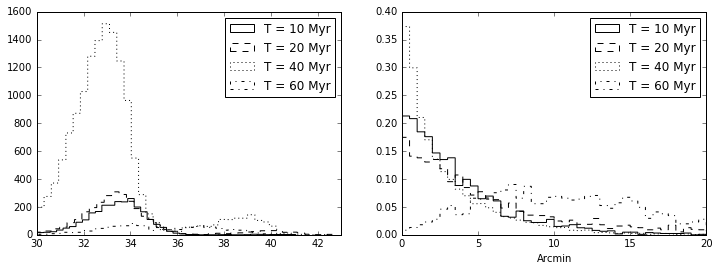

In [20]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

histrange=[0.0, 20.0]

t_obs = 10.0
M_1_b, M_2_b, A_b = func_MT_forward(M_1_a, M_2_a, A_a, ecc_a)
A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)
M_2_tmp, L_x_tmp, M_dot_out, A_d = func_Lx_forward(M_1_a, M_2_a, M_2_b, A_tmp, e_tmp, t_obs)
dist = v_sys_tmp * (t_obs - func_sse_tmax(M_1_a)) * km_to_cm / pc_to_cm * 1.0e6 * yr_to_sec
ran_theta_proj = get_theta(len(np.where(L_x_tmp>1.0e30)[0]))
angle_dist = np.abs(dist[L_x_tmp>1.0e30] * np.sin(ran_theta_proj) / dist_LMC / asec_to_rad * pc_to_km)/60.0
ax1.hist(np.log10(L_x_tmp[L_x_tmp>1.0e30]), color='k', histtype='step', linestyle='solid', bins=40, label='T = '+str(int(t_obs))+' Myr')
#ax2.hist(dist[L_x_tmp>1.0e30], color='k', histtype='step', linestyle='solid', bins=40, normed=True)
ax2.hist(angle_dist, color='k', range=histrange, histtype='step', linestyle='solid', bins=40, normed=True, label='T = '+str(int(t_obs))+' Myr')
print t_obs, "Myr:", len(np.where(L_x_tmp>1.0e30)[0])

t_obs = 20.0
M_1_b, M_2_b, A_b = func_MT_forward(M_1_a, M_2_a, A_a, ecc_a)
A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)
M_2_tmp, L_x_tmp, M_dot_out, A_d = func_Lx_forward(M_1_a, M_2_a, M_2_b, A_tmp, e_tmp, t_obs)
dist = v_sys_tmp * (t_obs - func_sse_tmax(M_1_a)) * km_to_cm / pc_to_cm * 1.0e6 * yr_to_sec
ran_theta_proj = get_theta(len(np.where(L_x_tmp>1.0e30)[0]))
angle_dist = np.abs(dist[L_x_tmp>1.0e30] * np.sin(ran_theta_proj) / dist_LMC / asec_to_rad * pc_to_km)/60.0
ax1.hist(np.log10(L_x_tmp[L_x_tmp>1.0e30]), color='k', histtype='step', linestyle='dashed', bins=40, label='T = '+str(int(t_obs))+' Myr')
#ax2.hist(dist[L_x_tmp>1.0e30], color='k', histtype='step', linestyle='dashed', bins=40, normed=True)
ax2.hist(angle_dist, color='k', range=histrange, histtype='step', linestyle='dashed', bins=40, normed=True, label='T = '+str(int(t_obs))+' Myr')
print t_obs, "Myr:", len(np.where(L_x_tmp>1.0e30)[0])

t_obs = 40.0
M_1_b, M_2_b, A_b = func_MT_forward(M_1_a, M_2_a, A_a, ecc_a)
A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)
M_2_tmp, L_x_tmp, M_dot_out, A_d = func_Lx_forward(M_1_a, M_2_a, M_2_b, A_tmp, e_tmp, t_obs)
dist = v_sys_tmp * (t_obs - func_sse_tmax(M_1_a)) * km_to_cm / pc_to_cm * 1.0e6 * yr_to_sec
ran_theta_proj = get_theta(len(np.where(L_x_tmp>1.0e30)[0]))
angle_dist = np.abs(dist[L_x_tmp>1.0e30] * np.sin(ran_theta_proj) / dist_LMC / asec_to_rad * pc_to_km)/60.0
ax1.hist(np.log10(L_x_tmp[L_x_tmp>1.0e30]), color='k', histtype='step', linestyle='dotted', bins=40, label='T = '+str(int(t_obs))+' Myr')
#ax2.hist(dist[L_x_tmp>1.0e30], color='k', histtype='step', linestyle='dotted', bins=40, normed=True)
ax2.hist(angle_dist, color='k', range=histrange, histtype='step', linestyle='dotted', bins=40, normed=True, label='T = '+str(int(t_obs))+' Myr')
print t_obs, "Myr:", len(np.where(L_x_tmp>1.0e30)[0])

t_obs = 60.0
i = 25
M_1_b, M_2_b, A_b = func_MT_forward(M_1_a, M_2_a, A_a, ecc_a)
A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)
M_2_tmp, L_x_tmp, M_dot_out, A_d = func_Lx_forward(M_1_a, M_2_a, M_2_b, A_tmp, e_tmp, t_obs)
dist = v_sys_tmp * (t_obs - func_sse_tmax(M_1_a)) * km_to_cm / pc_to_cm * 1.0e6 * yr_to_sec
ran_theta_proj = get_theta(len(np.where(L_x_tmp>1.0e30)[0]))
angle_dist = np.abs(dist[L_x_tmp>1.0e30] * np.sin(ran_theta_proj) / dist_LMC / asec_to_rad * pc_to_km)/60.0
ax1.hist(np.log10(L_x_tmp[L_x_tmp>1.0e30]), color='k', histtype='step', linestyle='dashdot', bins=40, label='T = '+str(int(t_obs))+' Myr')
#ax2.hist(dist[L_x_tmp>1.0e30], color='k', histtype='step', linestyle='dashdot', bins=40)
ax2.hist(angle_dist, color='k', range=histrange, histtype='step', linestyle='dashdot', bins=40, normed=True, label='T = '+str(int(t_obs))+' Myr')
print t_obs, "Myr:", len(np.where(L_x_tmp>1.0e30)[0])

ax1.set_xlim(30.0, 43.0)
ax1.legend()

ax2.set_xlim(0.0, 20.0)
ax2.set_xlabel("Arcmin")
ax2.legend()


#plt.savefig("../figures/forward_hist_HMXB.pdf")
plt.show()

### Run emcee

In [ ]:
start_time = time.time()

print M2_d, L_x, ra, dec

sampler = run_emcee(M2_d, L_x, ra, dec, nburn=10000, nsteps=60000)

print time.time()-start_time

In [ ]:
truths = [M1, M2, A, ecc, v_k, theta, phi, ra_b, dec_b, t_obs]
labels = [r"$M_1$", r"$M_2$", r"$A$", r"$e$", r"$v_k$", r"$\theta$", r"$\phi$", r"$\alpha_{\rm b}$", r"$\delta_{\rm b}$", r"$t_{\rm b}$"]
fig = corner.corner(sampler.flatchain, labels=labels, truths=truths)

plt.show()

In [ ]:
for i in range(sampler.dim):
    plt.figure()
    for chain in sampler.chain[...,i]:
        plt.plot(chain, alpha=0.25, color='k', drawstyle='steps')